In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Read data from CSV file
file_name = 'phy_cps.csv'
data = pd.read_csv(file_name, index_col=0, header=0, parse_dates=True)
# data = pd.read_csv(file_name, index_col=0, header=0)


# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Generate sequences and targets for LSTM
def create_sequences(data, n_timesteps):
    X, y = [], []
    for i in range(len(data) - n_timesteps):
        X.append(data[i:i+n_timesteps])
        y.append(data[i+n_timesteps])
    return np.array(X), np.array(y)

# Define parameters
n_timesteps = 10
n_features = data.shape[1]
latent_dim = 64
epochs = 50
batch_size = 32

# Prepare the dataset
X, y = create_sequences(data_scaled, n_timesteps)

# Split into training and test sets
split_idx = int(0.8 * len(X))
X_train, y_train = X[:split_idx], y[:split_idx]
X_test, y_test = X[split_idx:], y[split_idx:]

# Create LSTM model
model = Sequential()
model.add(LSTM(latent_dim, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
# model.fit(X_train, y_train, epochs=epochs)


# Function to forecast iteratively
def forecast_iterative(model, input_seq, n_forecast_steps):
    input_seq = input_seq.copy()
    predictions = []
    for _ in range(n_forecast_steps):
        pred = model.predict(input_seq)
        predictions.append(pred[:, -1, :])
        input_seq = np.concatenate((input_seq[:, 1:, :], pred[:, -1:, :]), axis=1)
    return np.array(predictions).transpose(1, 0, 2)

# Number of steps to forecast
n_forecast_steps = 5

# Select the last sequence from the test set for forecasting
input_seq = X_test[-1:]

# Forecast iteratively
forecasted_values = forecast_iterative(model, input_seq, n_forecast_steps)

# Inverse transform the scaled data
forecasted_values_inv = scaler.inverse_transform(forecasted_values[0])
y_test_inv = scaler.inverse_transform(y_test[:n_forecast_steps])

# Flatten the true and predicted values for metric calculation
y_true = y_test_inv
y_pred = forecasted_values_inv

# Compute and print the metrics for each feature
for i in range(n_features):
    true = y_true[:, i]
    pred = y_pred[:, i]
    
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true, pred)
    r2 = r2_score(true, pred)
    
    print(f'Feature {data.columns[i]}:')
    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'R2 Score: {r2:.4f}')
    print('')

# Plot the results (optional)
def plot_results(predictions, true_values, feature_name):
    plt.figure(figsize=(10, 6))
    plt.plot(true_values.flatten(), label='True')
    plt.plot(predictions.flatten(), label='Predicted')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title(f'{feature_name} Prediction vs True')
    plt.legend()
    plt.show()

# Plot each feature separately (optional)
for i in range(n_features):
    plot_results(y_pred[:, i], y_true[:, i], data.columns[i])


Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/mean_squared_error/BroadcastGradientArgs' defined at (most recent call last):
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance
      app.start()
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 461, in dispatch_queue
      await self.process_one()
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 450, in process_one
      await dispatch(*args)
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 357, in dispatch_shell
      await result
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 652, in execute_request
      reply_content = await reply_content
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2768, in run_cell
      result = self._run_cell(
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2814, in _run_cell
      return runner(coro)
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3012, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3191, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3251, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\user\AppData\Local\Temp\ipykernel_11512\3246235410.py", line 49, in <module>
      model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 863, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 530, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 583, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 464, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/mean_squared_error/BroadcastGradientArgs'
Incompatible shapes: [32,10,6] vs. [32,6]
	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_18622]

In [6]:
n_features

6

Epoch 1/100
61/61 [==============================] - 5s 26ms/step - loss: 0.0481 - val_loss: 0.0132
Epoch 2/100
61/61 [==============================] - 1s 12ms/step - loss: 0.0101 - val_loss: 0.0126
Epoch 3/100
61/61 [==============================] - 1s 12ms/step - loss: 0.0090 - val_loss: 0.0108
Epoch 4/100
61/61 [==============================] - 1s 12ms/step - loss: 0.0082 - val_loss: 0.0097
Epoch 5/100
61/61 [==============================] - 1s 12ms/step - loss: 0.0076 - val_loss: 0.0093
Epoch 6/100
61/61 [==============================] - 1s 12ms/step - loss: 0.0072 - val_loss: 0.0089
Epoch 7/100
61/61 [==============================] - 1s 13ms/step - loss: 0.0066 - val_loss: 0.0079
Epoch 8/100
61/61 [==============================] - 1s 13ms/step - loss: 0.0060 - val_loss: 0.0074
Epoch 9/100
61/61 [==============================] - 1s 14ms/step - loss: 0.0056 - val_loss: 0.0073
Epoch 10/100
61/61 [==============================] - 1s 14ms/step - loss: 0.0051 - val_loss: 0.0070

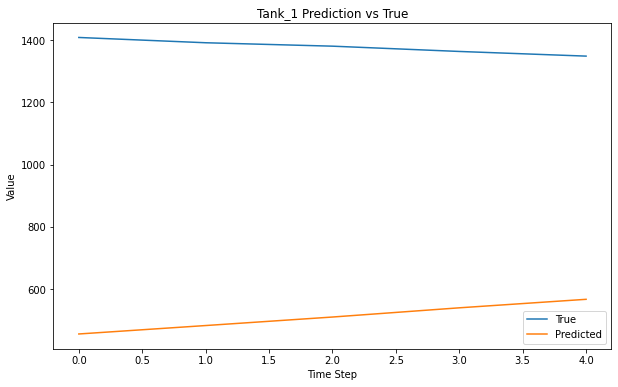

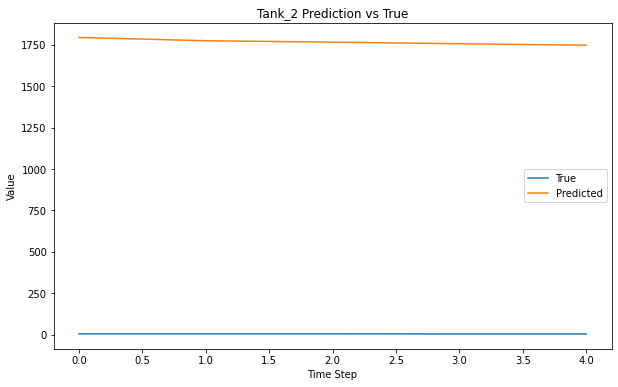

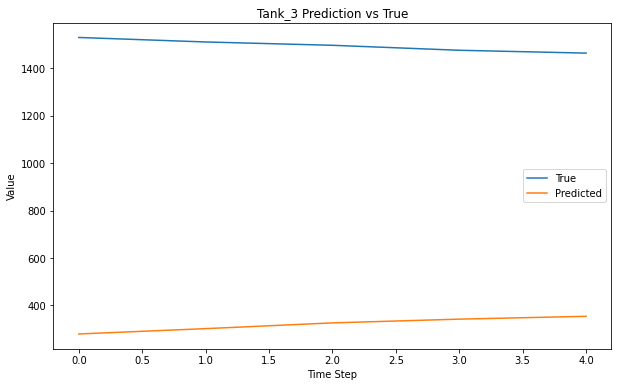

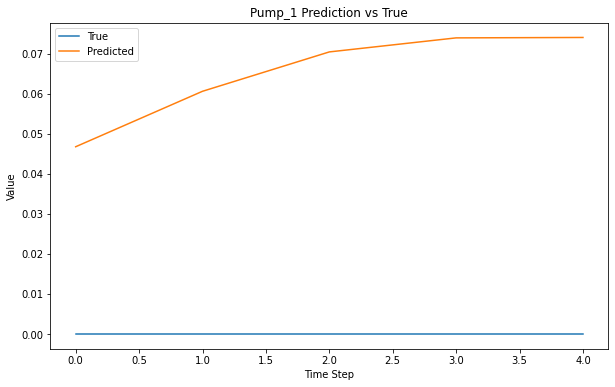

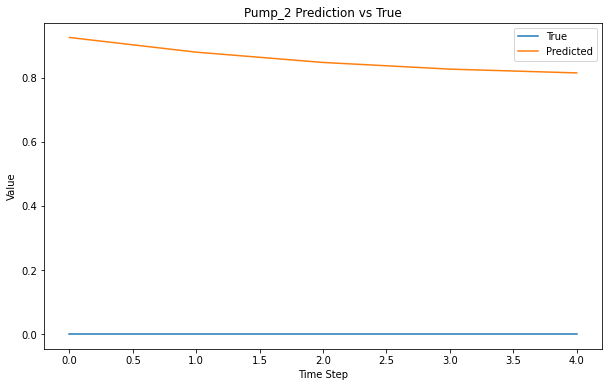

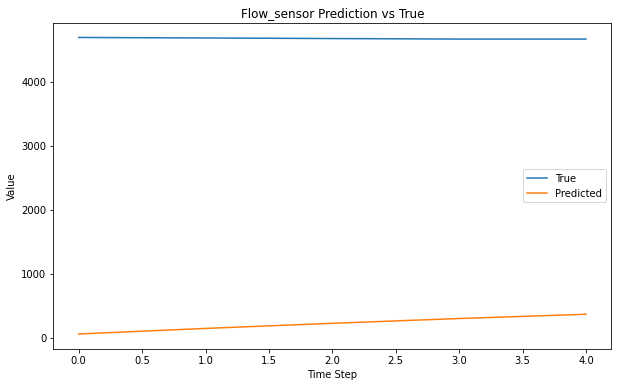

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Read data from CSV file
file_name = 'phy_cps.csv'
data = pd.read_csv(file_name, index_col='Time', parse_dates=True)
# file_name = 'waterTank_Golden_reduced.csv'
# data = pd.read_csv(file_name, index_col=0, header=0, parse_dates=True)
# data = pd.read_csv(file_name, index_col='time', parse_dates=True)

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Generate sequences and targets for LSTM
def create_sequences(data, n_timesteps):
    X, y = [], []
    for i in range(len(data) - n_timesteps):
        X.append(data[i:i+n_timesteps])
        y.append(data[i+n_timesteps])
    return np.array(X), np.array(y)

# Define parameters
n_timesteps = 10
n_features = data.shape[1]
latent_dim = 64
epochs = 100
batch_size = 32

# Prepare the dataset
X, y = create_sequences(data_scaled, n_timesteps)

# Split into training and test sets
split_idx = int(0.8 * len(X))
X_train, y_train = X[:split_idx], y[:split_idx]
X_test, y_test = X[split_idx:], y[split_idx:]

# Create LSTM model
model = Sequential()
# model.add(LSTM(latent_dim, input_shape=(n_timesteps, n_features), return_sequences=False))
model.add(LSTM(latent_dim, input_shape=(n_timesteps, n_features), return_sequences=True))
model.add(LSTM(latent_dim, return_sequences=False))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

# Function to forecast iteratively
def forecast_iterative(model, input_seq, n_forecast_steps):
    predictions = []
    input_seq = input_seq.copy()
    for _ in range(n_forecast_steps):
        pred = model.predict(input_seq)
        predictions.append(pred)
        input_seq = np.roll(input_seq, -1, axis=1)
        input_seq[:, -1, :] = pred
    return np.array(predictions).squeeze()

# Number of steps to forecast
n_forecast_steps = 5

# Select the last sequence from the test set for forecasting
input_seq = X_test[-1:].copy()

# Forecast iteratively
forecasted_values = forecast_iterative(model, input_seq, n_forecast_steps)

# Inverse transform the scaled data
forecasted_values_inv = scaler.inverse_transform(forecasted_values)
y_test_inv = scaler.inverse_transform(y_test[:n_forecast_steps])

# Flatten the true and predicted values for metric calculation
y_true = y_test_inv
y_pred = forecasted_values_inv

# Compute and print the metrics for each feature
for i in range(n_features):
    true = y_true[:, i]
    pred = y_pred[:, i]
    
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true, pred)
    r2 = r2_score(true, pred)
    
    print(f'Feature {data.columns[i]}:')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    print(f'R2 Score: {r2}')
    print('')

# Plot the results (optional)
def plot_results(predictions, true_values, feature_name):
    plt.figure(figsize=(10, 6))
    plt.plot(true_values.flatten(), label='True')
    plt.plot(predictions.flatten(), label='Predicted')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title(f'{feature_name} Prediction vs True')
    plt.legend()
    plt.show()

# Plot each feature separately (optional)
for i in range(n_features):
    plot_results(y_pred[:, i], y_true[:, i], data.columns[i])


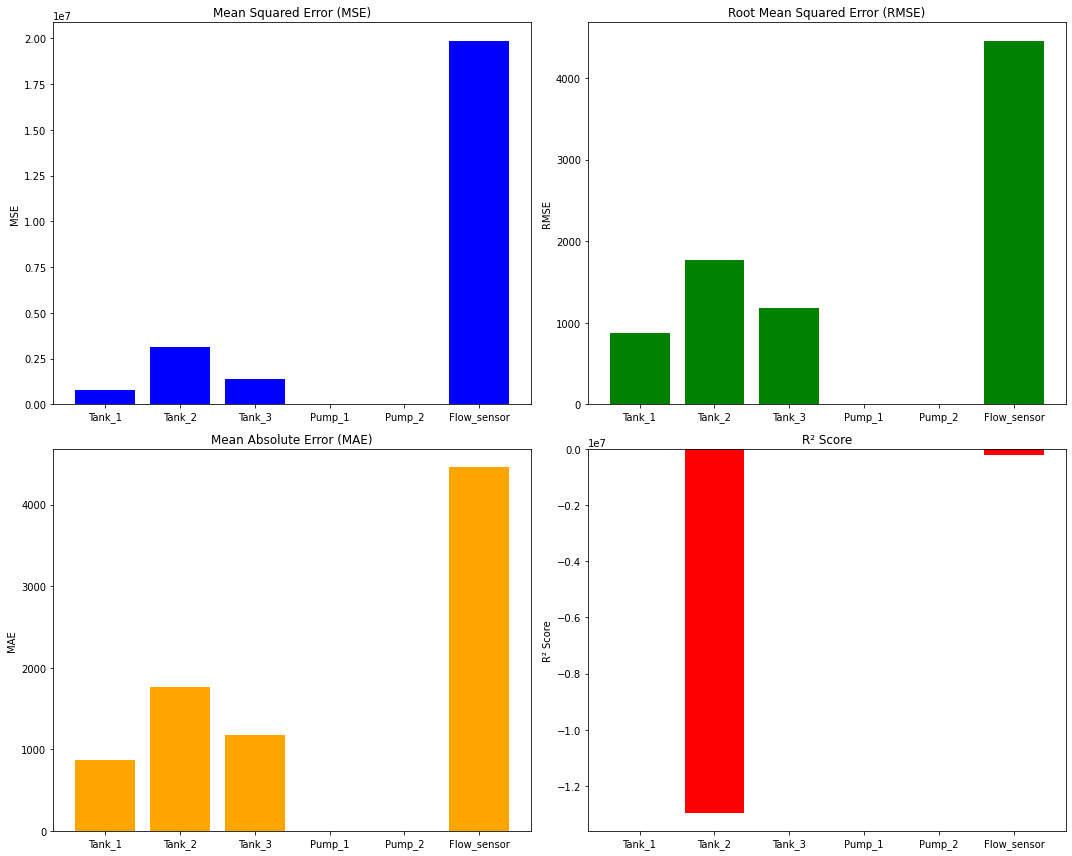

In [16]:
import matplotlib.pyplot as plt

# Define the metrics
features = ['Tank_1', 'Tank_2', 'Tank_3', 'Pump_1', 'Pump_2', 'Flow_sensor']
mse = [757731.0950999673, 3109165.80305959, 1382596.8834785665, 0.0043494441908173585, 0.7404678155747242, 19885478.376478434]
rmse = [870.4775098185864, 1763.2826781487959, 1175.8387999545544, 0.06595031607822179, 0.8605043960228932, 4459.313666527443]
mae = [868.3689453125, 1763.21279296875, 1174.7510375976562, 0.0651222050189972, 0.8595758557319642, 4457.730603790284]
r2_score = [-1722.6831098725372, -12954856.51274829, -2463.3463629662174, 0.0, 0.0, -208006.09598826812]

# Plot the metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot MSE
axes[0, 0].bar(features, mse, color='blue')
axes[0, 0].set_title('Mean Squared Error (MSE)')
axes[0, 0].set_ylabel('MSE')

# Plot RMSE
axes[0, 1].bar(features, rmse, color='green')
axes[0, 1].set_title('Root Mean Squared Error (RMSE)')
axes[0, 1].set_ylabel('RMSE')

# Plot MAE
axes[1, 0].bar(features, mae, color='orange')
axes[1, 0].set_title('Mean Absolute Error (MAE)')
axes[1, 0].set_ylabel('MAE')

# Plot R2 Score
axes[1, 1].bar(features, r2_score, color='red')
axes[1, 1].set_title('R² Score')
axes[1, 1].set_ylabel('R² Score')

# Adjust layout
plt.tight_layout()
plt.show()


Epoch 1/100
61/61 [==============================] - 9s 35ms/step - loss: 0.0430 - val_loss: 0.0138
Epoch 2/100
61/61 [==============================] - 1s 15ms/step - loss: 0.0093 - val_loss: 0.0108
Epoch 3/100
61/61 [==============================] - 1s 15ms/step - loss: 0.0083 - val_loss: 0.0094
Epoch 4/100
61/61 [==============================] - 1s 15ms/step - loss: 0.0078 - val_loss: 0.0088
Epoch 5/100
61/61 [==============================] - 1s 15ms/step - loss: 0.0070 - val_loss: 0.0080
Epoch 6/100
61/61 [==============================] - 1s 14ms/step - loss: 0.0064 - val_loss: 0.0078
Epoch 7/100
61/61 [==============================] - 1s 14ms/step - loss: 0.0062 - val_loss: 0.0069
Epoch 8/100
61/61 [==============================] - 1s 13ms/step - loss: 0.0055 - val_loss: 0.0078
Epoch 9/100
61/61 [==============================] - 1s 15ms/step - loss: 0.0053 - val_loss: 0.0063
Epoch 10/100
61/61 [==============================] - 1s 15ms/step - loss: 0.0048 - val_loss: 0.0060

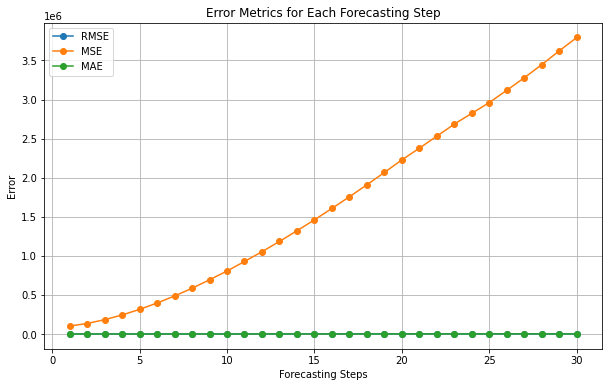

In [18]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from sklearn.preprocessing import MinMaxScaler

# Read data from CSV file
file_name = 'phy_cps.csv'
data = pd.read_csv(file_name, index_col='Time', parse_dates=True)

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Generate sequences and targets for LSTM
def create_sequences(data, n_timesteps):
    X, y = [], []
    for i in range(len(data) - n_timesteps):
        X.append(data[i:i+n_timesteps])
        y.append(data[i+n_timesteps])
    return np.array(X), np.array(y)

# Define parameters
n_timesteps = 10
n_features = data.shape[1]
latent_dim = 64
epochs = 100
batch_size = 32

# Prepare the dataset
X, y = create_sequences(data_scaled, n_timesteps)

# Split into training and test sets
split_idx = int(0.8 * len(X))
X_train, y_train = X[:split_idx], y[:split_idx]
X_test, y_test = X[split_idx:], y[split_idx:]

# Create LSTM model with additional LSTM layer
model = Sequential()
model.add(LSTM(latent_dim, input_shape=(n_timesteps, n_features), return_sequences=True))
model.add(LSTM(latent_dim, return_sequences=False))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

# Function to forecast iteratively and calculate errors
def forecast_iterative_with_errors(model, input_seq, n_forecast_steps, true_values):
    predictions = []
    errors = {'rmse': [], 'mse': [], 'mae': []}
    input_seq = input_seq.copy()
    for i in range(n_forecast_steps):
        pred = model.predict(input_seq)
        predictions.append(pred)
        input_seq = np.roll(input_seq, -1, axis=1)
        input_seq[:, -1, :] = pred
        
        # Calculate errors
        pred_inv = scaler.inverse_transform(pred)
        true_inv = scaler.inverse_transform(true_values[i:i+1])
        mse = mean_squared_error(true_inv, pred_inv)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(true_inv, pred_inv)
        errors['mse'].append(mse)
        errors['rmse'].append(rmse)
        errors['mae'].append(mae)
    return np.array(predictions).squeeze(), errors

# Number of steps to forecast
n_forecast_steps = 30

# Select the last sequence from the test set for forecasting
input_seq = X_test[-1:].copy()
true_values = y_test[-n_forecast_steps:]

# Forecast iteratively and get errors
forecasted_values, errors = forecast_iterative_with_errors(model, input_seq, n_forecast_steps, true_values)

# Plot the error metrics for each iteration
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_forecast_steps + 1), errors['rmse'], marker='o', label='RMSE')
plt.plot(range(1, n_forecast_steps + 1), errors['mse'], marker='o', label='MSE')
plt.plot(range(1, n_forecast_steps + 1), errors['mae'], marker='o', label='MAE')
plt.xlabel('Forecasting Steps')
plt.ylabel('Error')
plt.title('Error Metrics for Each Forecasting Step')
plt.legend()
plt.grid(True)
plt.show()


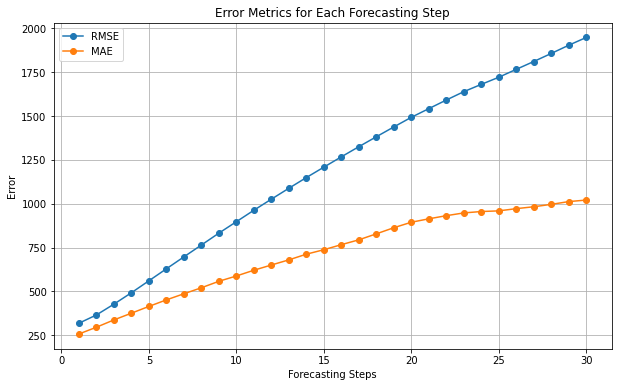

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_forecast_steps + 1), errors['rmse'], marker='o', label='RMSE')
# plt.plot(range(1, n_forecast_steps + 1), errors['mse'], marker='o', label='MSE')
plt.plot(range(1, n_forecast_steps + 1), errors['mae'], marker='o', label='MAE')
plt.xlabel('Forecasting Steps')
plt.ylabel('Error')
plt.title('Error Metrics for Each Forecasting Step')
plt.legend()
plt.grid(True)
plt.show()